<a href="https://colab.research.google.com/github/JxxnDx/Notebooks/blob/main/2_LSTM_TextGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Text generation with a LSTM (PyTorch) - TALLER 1

**Goal:** How to build, train and evaluate a Long Short Term Memory (LSTM) to generate text sequences.

**Steps:**
- How to prepare text sequences
- How to build a LSTM with `nn.LSTM`
- Training and validation loops
- Visualizing results and making predictions
- Looking at the LSTM gates `nn.LSTMCell`


In [9]:
#@title 1. Imports and setup
import math, random, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, random_split

## Device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [ ]:
#@title 2. MONTAR EL DRIVE  (If you are in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
# Please replace '/content/drive/My Drive/Shared with me/Colab Notebooks IA3' with the correct path to your folder
os.chdir('/content/drive/My Drive/IA III')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/IA III


In [ ]:
#@title 3. Load text sample
# load ascii text and convert to lowercase
filename = "data/cien-as-full.txt" ##"data/cien-as-full.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  817675
Total Vocab:  61


In [ ]:
#@title 4. Data preparation
# prepare the dataset of input to output pairs encoded as integers
seq_length = 30
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  817645


In [ ]:
#@title 5. Convert to PyTorch tensors
# reshape X to be [samples, time steps, features]
X = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X = X / float(n_vocab)
y = torch.tensor(dataY)
print(X.shape, y.shape)

torch.Size([817645, 30, 1]) torch.Size([817645])


In [ ]:
class CharModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(512, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x) # Add this line to pass through LSTM
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [ ]:
#@title 7. Define parameters
n_epochs = 15
batch_size = 32
model = CharModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")
dataset = data.TensorDataset(X.to(device), y.to(device)) #
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)

In [ ]:
#@title 8. Perform training and validation
from tqdm.notebook import trange

best_model = None
best_loss = np.inf

train_losses = []
val_losses = []

for epoch in trange(n_epochs, desc="Training"):
    model.train()
    current_train_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(loader.dataset))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += loss_fn(y_pred, y_batch).item()
    val_losses.append(val_loss / len(loader.dataset))

    # Check best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()

    # Print and flush so Colab shows output immediately
    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {current_train_loss / len(loader.dataset):.4f} - Validation Loss: {val_loss / len(loader.dataset):.4f}", flush=True)

torch.save([best_model, char_to_int, train_losses, val_losses], "my_model_fragment_10ep.pth")


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 - Training Loss: 2.5304 - Validation Loss: 2.2626
Epoch 2/15 - Training Loss: 2.1820 - Validation Loss: 1.9934
Epoch 3/15 - Training Loss: 2.0004 - Validation Loss: 1.8620
Epoch 4/15 - Training Loss: 1.8901 - Validation Loss: 1.7484
Epoch 5/15 - Training Loss: 1.8122 - Validation Loss: 1.6840
Epoch 6/15 - Training Loss: 1.7545 - Validation Loss: 1.6210
Epoch 7/15 - Training Loss: 1.7088 - Validation Loss: 1.5754
Epoch 8/15 - Training Loss: 1.6698 - Validation Loss: 1.5459
Epoch 9/15 - Training Loss: 1.6387 - Validation Loss: 1.5208
Epoch 10/15 - Training Loss: 1.6103 - Validation Loss: 1.4953
Epoch 11/15 - Training Loss: 1.5862 - Validation Loss: 1.4539
Epoch 12/15 - Training Loss: 1.5652 - Validation Loss: 1.4382
Epoch 13/15 - Training Loss: 1.5449 - Validation Loss: 1.4142
Epoch 14/15 - Training Loss: 1.5260 - Validation Loss: 1.3948
Epoch 15/15 - Training Loss: 1.5103 - Validation Loss: 1.3813


In [ ]:
#@title 9. Evaluate and get results
import numpy as np
import torch
import torch.nn as nn

best_model, char_to_int, train_losses, val_losses = torch.load("my_model_fragment_10ep.pth")
n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())

# reload the model
class CharModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(512, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x
model = CharModel()
model.load_state_dict(best_model)

# randomly generate a prompt
filename = "data/cien-as-fragment.txt"
seq_length = 100
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
start = np.random.randint(0, len(raw_text)-seq_length)
prompt = raw_text[start:start+seq_length]
pattern = [char_to_int[c] for c in prompt]

model.eval()
print('Prompt: "%s"' % prompt)
with torch.no_grad():
    for i in range(100):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model(x)
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
print()
print("Done.")

Prompt: " del crepúsculo. desconcertado, sabiendo que los niños esperaban una 
explicación inmediata, josé ar"
cadio buendía se le había aooenado los pergaminos de la casa. aureliano segundo se le había aloarado
Done.


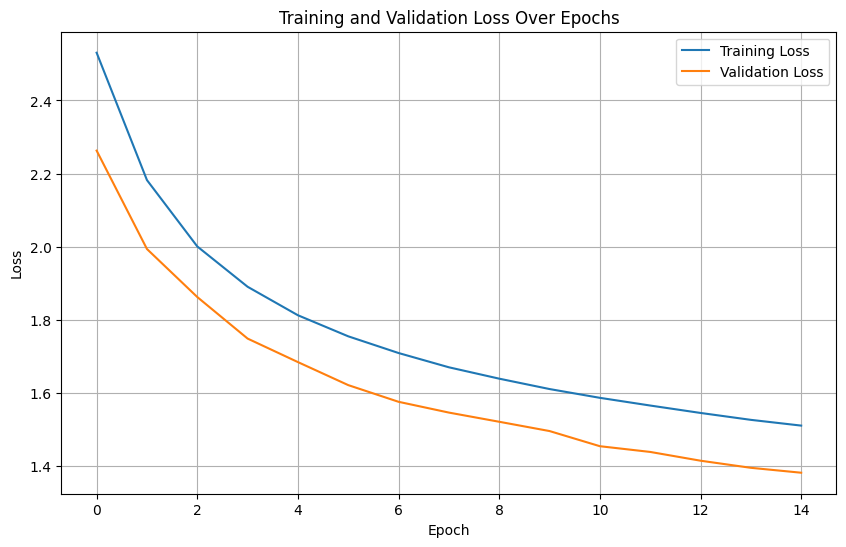

In [ ]:
#@title 10. Results visualization
import matplotlib.pyplot as plt

# Load the saved model and losses
best_model, char_to_int, train_losses, val_losses = torch.load("my_model_fragment_10ep.pth")

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#@title 11. Train your own LSTM

import torch.nn as nn

# Define the LSTM model
class CharModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(512, n_vocab) # Changed from 256 to 512 to match LSTM hidden_size
    def forward(self, x):
        x, _ = self.lstm(x) # Pass input through LSTM
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

# parameters
n_epochs = 15
batch_size = 64
model2 = CharModel2().to(device)
optimizer = optim.Adam(model2.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")
dataset = data.TensorDataset(X.to(device), y.to(device))
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)

# Perform training and validation
from tqdm.notebook import trange

best_model = None
best_loss = np.inf

train_losses = []
val_losses = []

for epoch in trange(n_epochs, desc="Training"):
    model2.train()
    current_train_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model2(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(loader.dataset))

    # Validation
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model2(X_batch)
            val_loss += loss_fn(y_pred, y_batch).item()
    val_losses.append(val_loss / len(loader.dataset))

    # Check best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model2.state_dict()

    # Print and flush so Colab shows output immediately
    print(f"Epoch {epoch+1}/{n_epochs} - Training Loss: {current_train_loss / len(loader.dataset):.4f} - Validation Loss: {val_loss / len(loader.dataset):.4f}", flush=True)

torch.save([best_model, char_to_int, train_losses, val_losses], "my_model_fragment_10ep.pth")

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 - Training Loss: 2.1710 - Validation Loss: 1.7616
Epoch 2/15 - Training Loss: 1.7279 - Validation Loss: 1.5291
Epoch 3/15 - Training Loss: 1.5725 - Validation Loss: 1.4047
Epoch 4/15 - Training Loss: 1.4846 - Validation Loss: 1.3448
Epoch 5/15 - Training Loss: 1.4249 - Validation Loss: 1.2878
Epoch 6/15 - Training Loss: 1.6086 - Validation Loss: 2.0713
Epoch 7/15 - Training Loss: 1.8497 - Validation Loss: 1.5779
Epoch 8/15 - Training Loss: 1.6061 - Validation Loss: 1.4410
Epoch 9/15 - Training Loss: 1.5003 - Validation Loss: 1.3576
Epoch 10/15 - Training Loss: 1.4339 - Validation Loss: 1.3181
Epoch 11/15 - Training Loss: 1.3868 - Validation Loss: 1.2896
Epoch 12/15 - Training Loss: 1.3518 - Validation Loss: 1.2873
Epoch 13/15 - Training Loss: 1.3235 - Validation Loss: 1.2009
Epoch 14/15 - Training Loss: 1.3019 - Validation Loss: 1.1845
Epoch 15/15 - Training Loss: 1.2827 - Validation Loss: 1.1603


In [ ]:
#@title Evaluate and get results
import numpy as np
import torch
import torch.nn as nn

best_model, char_to_int, train_losses, val_losses = torch.load("my_model_fragment_10ep.pth")
n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())

# reload the model
class CharModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(512, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x
model2 = CharModel2()
model2.load_state_dict(best_model)

# randomly generate a prompt
filename = "data/cien-as-full.txt"
seq_length = 30
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
start = np.random.randint(0, len(raw_text)-seq_length)
prompt = raw_text[start:start+seq_length]
pattern = [char_to_int[c] for c in prompt]

model2.eval()
print('Prompt: "%s"' % prompt)
with torch.no_grad():
    for i in range(100):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model2(x)
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
print()
print("Done.")

Prompt: "ar será preguntar por él, y le"
 dio una casa de convertirle en la casa de la casa de la casa de la casa de la casa de la casa de la
Done.


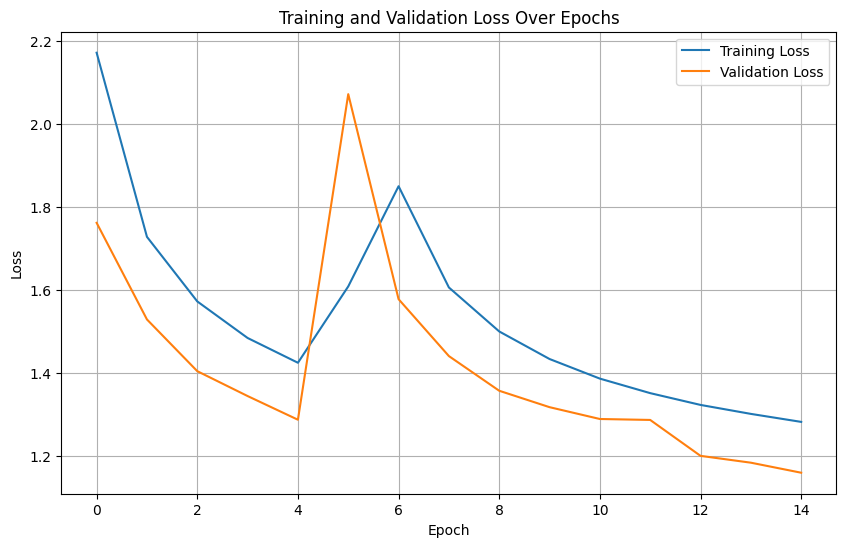

In [ ]:
# Results visualization
import matplotlib.pyplot as plt

# Load the saved model and losses
best_model, char_to_int, train_losses, val_losses = torch.load("my_model_fragment_10ep.pth")

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


12. Looking at the LSTM gates
- We can't directly play with the LSTM gates in the standard `nn.LSTM` module, because PyThorch doesn't expose the gates by default.
- Use `nn.Module` to create the same LSTM. In this way you can have access to the gates

In [ ]:
i_mean = i_gates.mean(dim=(1,2)).cpu().numpy()
f_mean = f_gates.mean(dim=(1,2)).cpu().numpy()
o_mean = o_gates.mean(dim=(1,2)).cpu().numpy()

plt.figure(figsize=(12,6))
plt.plot(i_mean, label="Input Gate")
plt.plot(f_mean, label="Forget Gate")
plt.plot(o_mean, label="Output Gate")
plt.xlabel("Timestep")
plt.ylabel("Mean Activation")
plt.title("Evolution of LSTM Gates")
plt.legend()
plt.grid()
plt.show()

**EXERCISES**


**1. Describe graphically the data (text sequences). Play with the data hyperparameters (Test the cien-as-full.txt if possible).**

R/
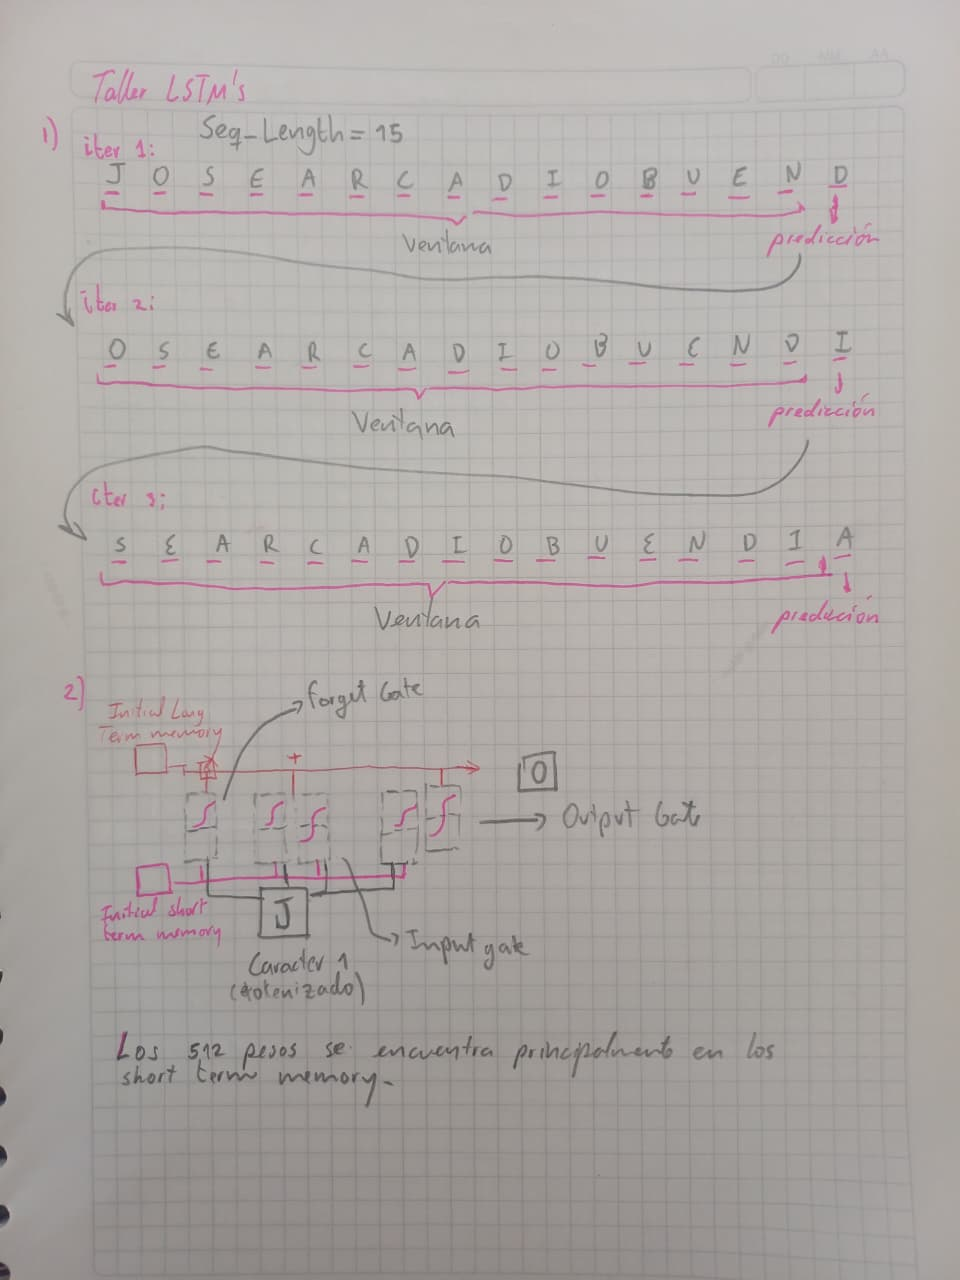

Efectivamente se cambió el texto del fragmento al completo. Se modificaron distintos hiperparametros como el num_layers (demora mucho más en compilar y genera un poco más de ruido en las gráficas de perdida), el número de neuronas y el batch_size. Finalmente después de distintas pruebas, se dejan los hiperparametros con los que se obtienen los mejores resultados.


**2. Play with the LSTM parameters. Sketch the architecture. Which change produces a noticeable difference in the results?, Explain.**

R/ Para la primera arquitectura (del taller) se le aumentó el número de neuronas de 256 a 512 y el batch_size a 64, pero finalmente se dejó en 32. El cambio más significativo que se ve, es que la perdida tanto de entrenamiento como la de validación disminuyen, sin evidenciarse sobreajuste. Además de que el texto generado tiene más sentido a la hora de predecir que sigue.


**3. Complete the results visualization code cell with the analysis you consider is required to decide that your model is working**

R/ Se grafican las perdidas tanto de entrenamiento como de validación para verificar que no se halla presentado un overfitting, lo cual no es el caso.

**4. Perform trainings with different hyperparameters, select the best and report the evaluations. Do you notice differences in the results with the given model?**

R/ Los mejores resultados obtenidos en la primera arquitectura fueron una perdida de entrenamiento de 1.51 y una perdida de validación de 1.38, lo que quiere decir que los cambios tuvieron un efecto en bajar un poco la perdida y que el modelo genere predicciones del texto con más sentido y coherencia.

**5. Train your own model (Changing hyperparameters AND the model itself) and report the differences with the given model. (Be prepared to require GPU and time)**

R/ A comparación del modelo dado con el propuesto, se aumentó el número de neuronas a 512, el número de epocas a 15 y el batch_size a 64, ademas de agregar una capa más. Logra disminuir aún más las perdidas de entrenamiento y validación, 1.28 y 1.16 respectivamente. Sin embargo, a la hora de generar predicciones del texto, tiende a fallar al entrar en bucles de ciertas palabras, como por ejemplo, en frases como "de la casa" el modelo entra en un bucle a predecir siempre lo mismo, esto, porque se asigna una probabilidad muy alta de predicción a la esta misma secuencia, la cual causa que se siga retroalimentandose a si mismo generando esta secuencia repetitiva.

**6. Let's examine the LSTM gates. Use 'nn.LSTMCell' to re-implement the given model. Play with the gates, report the process, explain the implementation, show the results.**

R/ La implementación con nn.LSTMCell permitió analizar el comportamiento interno del modelo paso a paso. Aunque el rendimiento final fue similar al modelo con nn.LSTM el uso explícito del loop/ciclo temporal facilitó la comprensión de las compuertas y del mecanismo de actualización del estado de memoria. Las pruebas mostraron que la inicialización y el tamaño del estado oculto influyen significativamente en la estabilidad y calidad del texto generado.